In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time, sys
import random
import pickle
from tqdm import tqdm

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math

import torch
import pytest
from einops import rearrange

from monarch.blockdiag_butterfly_multiply import blockdiag_butterfly_multiply_reference
from monarch.blockdiag_butterfly_multiply import blockdiag_butterfly_multiply
from monarch.blockdiag_butterfly_einsum import (
    blockdiag_butterfly_multiply_einsum_simple, blockdiag_butterfly_project_einsum_simple,
    blockdiag_butterfly_multiply_einsum, blockdiag_butterfly_project_einsum,
    blockdiag_butterfly_multiply_einsum_rank, blockdiag_butterfly_project_einsum_rank
)

In [3]:
np.random.seed(1001)
random.seed(1001)

In [4]:
rank_mlr = 28
mtype = "dgt_monarch"


with open("../outputs/matrix_gauss_allL.pickle", "rb") as f:
       A = pickle.load(f)

with open("../outputs/hpart_uni_gauss_allL.pickle", "rb") as f:
       hpart = pickle.load(f)

m = A.shape[0]
n = A.shape[1]

A1 = mf.dgt_matrix(m, n, d=3, k=5)
print(f"{mf.rel_diff(A, A1)=}, {np.allclose(A, A1)=}")

symm = np.allclose(A, A.T) if m==n else False
mlr_storage = rank_mlr * (m + n)
if symm:
       print(f"MLR storage = {rank_mlr * m}")
       mlr_storage /= 2
else:
       print(f"MLR storage = {rank_mlr * (m + n)}")

mf.rel_diff(A, A1)=8.863066645557482e-18, np.allclose(A, A1)=True
MLR storage = 336000


In [5]:
np.linalg.norm(A1, ord='fro'), np.linalg.norm(A, ord='fro')

(656.8103904504928, 656.8103904504928)

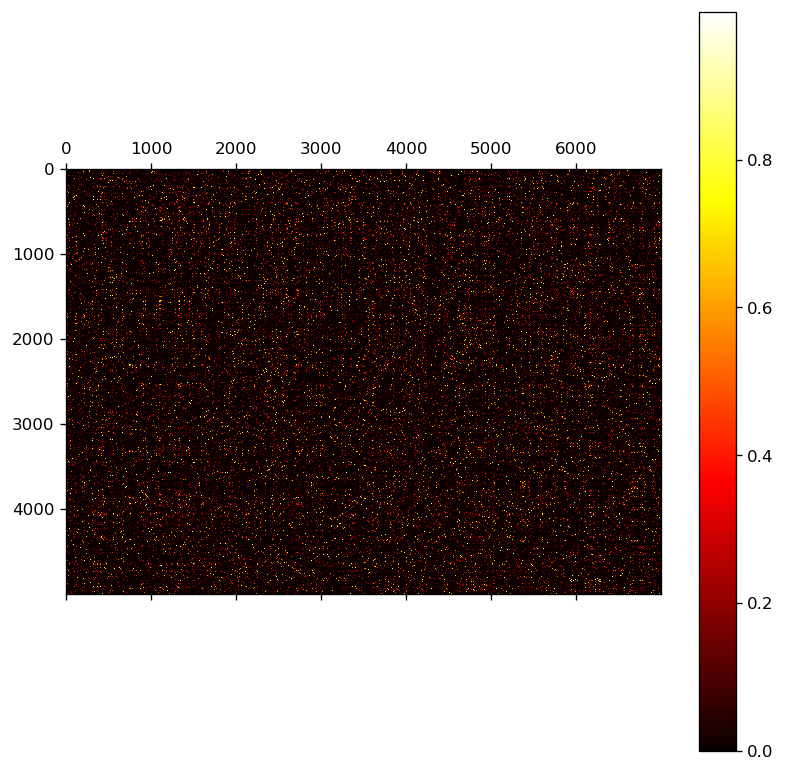

In [6]:
fig = plt.figure(figsize=(8, 8), dpi=120)
ax = fig.add_subplot(111)
cax = ax.matshow(A, cmap='hot')
fig.colorbar(cax)
plt.show()

In [7]:
m, n, mlr_storage

(5000, 7000, 336000)

In [8]:
n3 = m; n1 = n
b3, b1 = 2500, 3500
rank = 15
monarch_storage = (n3/b3 * b3 * rank*n1/b1) + (n1/b1 * rank*n3/b3 * b1) 
print(int(n1/b1), int(n3/b3))
print(f"{monarch_storage = }")

2 2
monarch_storage = 360000.0


In [9]:
pi_rows = hpart['rows']['pi']
pi_cols = hpart['cols']['pi']
pi_inv_rows, pi_inv_cols = mf.inv_permutation(pi_rows, pi_cols)
perm_A_torch = torch.from_numpy(A).float().to(mf.get_device())[pi_rows, :][:, pi_cols]
perm_A_torch.shape

torch.Size([5000, 7000])

In [10]:
w1_bfly_projected, w2_bfly_projected = blockdiag_butterfly_project_einsum_rank(perm_A_torch,
                                                                                nblocks1=n1//b1,
                                                                                nblocks2=n3//b3,
                                                                                rank=rank)
print(w1_bfly_projected.shape, w2_bfly_projected.shape)
assert ( np.prod(w1_bfly_projected.shape) + np.prod(w2_bfly_projected.shape) == monarch_storage)
x = torch.eye(n).to(mf.get_device())

M_torch = blockdiag_butterfly_multiply_einsum_rank(x, w1_bfly_projected,
                                                            w2_bfly_projected).t()

A_monarch = M_torch.cpu().detach().numpy()[pi_inv_rows, :][:, pi_inv_cols]
print(mf.rel_diff(A_monarch, den=A), M_torch.shape)

torch.Size([2, 30, 3500]) torch.Size([2, 2500, 30])
0.4396237419480157 torch.Size([5000, 7000])


In [12]:
print(f"err={mf.rel_diff(A_monarch, den=A)},   {monarch_storage=}, {b1=}, {b3=}, {rank=}")

err=0.4396237419480157,   monarch_storage=360000.0, b1=3500, b3=2500, rank=15


In [13]:
# err=0.4396237419480157,   monarch_storage=360000.0, b1=3500, b3=2500, rank=15

In [14]:
print(f"{monarch_storage=}")
print(f"    {mlr_storage=}")
print(f"         {m * n =}")
print(f"{m*n - monarch_storage=}")
mlr_storage * 1./ monarch_storage

monarch_storage=360000.0
    mlr_storage=336000
         m * n =35000000
m*n - monarch_storage=34640000.0


0.9333333333333333

In [15]:
# LR             0.4177886748298519
# LR+D           0.4274107034651386
# RA uniform     0.2176561255268253
# RA bottom      0.1675317813793931
# RA top         0.2575911845483002

In [16]:
hpart = mf.random_hpartition(m, n, num_levels=1, symm=symm, perm=False)
B1, C1 = mf.single_level_factor_fit(A, np.array([rank_mlr]), hpart, level=0, symm=symm, PSD=False)[:2]
print(mf.rel_diff(B1 @C1.T, den=A))

0.41778867482963766


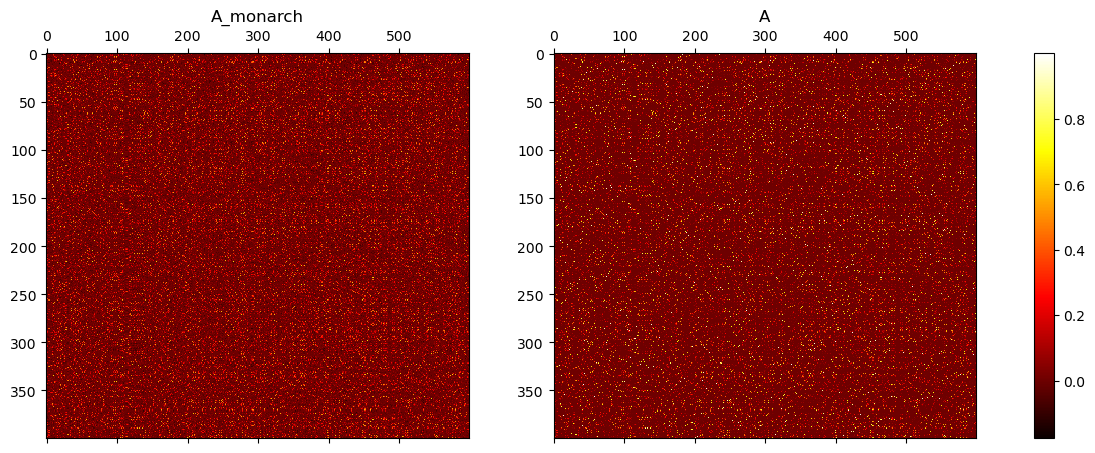

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
vmin = min(A.min(), A_monarch.min())
vmax = max(A.max(), A_monarch.max())
perm_A_monarch = A_monarch[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax1 = axs[0].matshow(perm_A_monarch[:400,:600], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('A_monarch')
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax2 = axs[1].matshow(perm_A[:400, :600], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('A')

fig.colorbar(cax1, ax=axs, orientation='vertical')
plt.show()